In [1]:
# Standard imports
import copy
import corner
import numpy as np
from tqdm import tqdm
from copy import deepcopy
import matplotlib.pyplot as plt
from itertools import combinations
from IPython.display import display, Markdown, Math
from mpl_toolkits.axes_grid1 import make_axes_locatable
from ltsfit.ltsfit import ltsfit


# Astropy imports
from astropy.table import Table

# Lenstronomy, HierArc imports
from hierarc.Sampling.ParamManager.cosmo_param import CosmoParam
# from likelihoods_parallel import beta2theta_e_ratio, beta_double_source_plane
from hierarc.Likelihood.LensLikelihood.double_source_plane import (
    beta_double_source_plane, beta2theta_e_ratio
)

# set global plotting parameters for academic paper
# plt.rcParams.update({
#     "font.size": 12,
#     "axes.labelsize": 14,
#     "axes.titlesize": 14,
#     "xtick.labelsize": 12,
#     "ytick.labelsize": 12,
#     "legend.fontsize": 12,
#     "figure.titlesize": 16,
#     "figure.figsize": (8, 6),
#     "lines.linewidth": 1.5,
#     "lines.markersize": 6,
#     "font.family": "serif",
#     "text.usetex": True,
# })

# Fit plane to the data
def fit_plane(x, y, z):
    """Fit a plane to the data points (x, y, z). The plane is z = ax + by + c."""

    # don't use nans or infs
    x = np.array(x)
    y = np.array(y)
    z = np.array(z)
    mask = np.isfinite(x) & np.isfinite(y) & np.isfinite(z)
    x = x[mask]
    y = y[mask]
    z = z[mask]

    A = np.c_[x, y, np.ones_like(x)]
    coeffs, _, _, _ = np.linalg.lstsq(A, z, rcond=None)
    return coeffs

# Find the scatter of the data points from the fitted plane
def find_scatter(x, y, z, coeffs, return_fit=False):
    """Find the scatter of the data points from the fitted plane. Return ``z - z_fit``."""

    # don't use nans or infs
    x = np.array(x)
    y = np.array(y)
    z = np.array(z)
    mask = np.isfinite(x) & np.isfinite(y) & np.isfinite(z)
    x = x[mask]
    y = y[mask]
    z = z[mask]

    z_fit = coeffs[0] * x + coeffs[1] * y + coeffs[2]
    scatter = z - z_fit
    if return_fit:
        return scatter, z_fit
    else:
        return scatter

In [3]:
# load the GGL data tables with different sky areas of lenses bu galaxy population is on 10 deg^2
sky_area = "50.0v2"
GGL_data_table = Table.read(f"../data/GGL_{sky_area}_SQDEG_RED_DEFLECTOR_BLUE_SOURCE.fits", format='fits')
GGL_data_table

lens_id,z_D,z_S,theta_E,sigma_v_D,mag_S_i,mag_S_r,mag_S_g,mag_S_z,mag_S_y,mag_D_i,mag_D_r,mag_D_g,mag_D_z,mag_D_y,size_D,e1_mass_D,e2_mass_D,e_mass_D,gamma_pl,R_e_kpc,Sigma_half_Msun/pc2,surf_bri_mag/arcsec2
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64
0,1.1395730540197462,2.721757883923871,0.6383209474735921,234.52827079090258,25.933963738373834,26.127290551620234,26.254675998006924,25.877372770610663,25.77967242684352,22.98925557393261,24.057250718125182,25.178428704908463,22.13937039113474,21.469667400192904,0.5236284022464591,-0.2185177432823041,0.0403576488557333,0.22221328481968317,2,4.30707590221643,6033.914441400326,26.23568913352215
1,1.1676192009673254,2.838231941243875,0.5428598143754139,215.84729996869848,24.22762289989987,24.307252461915994,24.330966194829777,24.19614120355442,24.25840995562706,23.4402925996813,24.481996698219838,25.35590571629431,22.647451548717875,21.931126586377424,0.2833098895986966,0.01249637671998382,-0.11601750873715334,0.11668856741216427,2,2.339785570397245,9636.754519164577,25.086016539203026
2,0.8496635018062778,3.3535717429740073,0.641000768077548,198.8149905902349,25.559769535693853,25.692328159661358,26.0026527226674,25.435595481739007,25.34701222772341,21.96306329205506,22.827566278001065,23.54640956678392,21.2303460229086,20.962437814004915,0.23774477841756192,0.0316484729535937,0.16867423476209303,0.17161766608619294,2,1.820585794159507,9782.545548619119,22.86143073655398
3,1.5030247928909466,2.1037429248665225,0.5111993143704567,314.13299407421005,26.510924542753955,26.70858277146902,27.1583892110041,26.131180343134147,25.81278128068294,23.77862974498593,25.346268769963384,26.00807169213301,22.905058039418602,22.357811050847626,1.4659095665465913,-0.009356050373493305,-0.025632148189255435,0.027286309742933265,2,12.406290085901004,3755.908492949182,29.310824741747
4,0.09931798255962809,2.1700020122674757,0.8909096122755212,182.91937545558415,26.068800062516363,26.18260302373776,26.453438870162888,25.85431274554333,25.597538901622872,15.682406808159396,16.184348056972592,17.024734167739563,15.371562734687448,15.1519986272104,1.8882089102964354,-0.03149400430312179,0.020689174501004406,0.03768174954242524,2,3.4613724155333387,993.0878825186128,20.86717108100093
5,0.5288078808555957,4.343158907234654,1.8475198758908336,295.8237930636839,26.489822086076952,26.713722342261637,27.968750435273822,26.51430656934446,26.36029223477607,18.820681063983304,19.673589738103377,20.940708005983755,18.453013637031862,18.219862227367084,1.3974704615046138,-0.037506289136146086,0.029683186537268865,0.04783109122496046,2,8.783981475448723,4329.28295528526,24.12990678858026
6,1.4559015868937206,3.8947692755843875,0.6865247003713678,244.97777562316497,26.6810933315858,26.722212903637512,27.36112014871479,26.47404290286856,26.398807903193074,24.046814542508628,25.29251052208788,25.617233245782813,23.347386960561984,22.7428989776878,0.3386182857665169,-0.03450844210644334,-0.04499833975555973,0.056706993901727315,2,2.862031469438829,11700.201951750312,25.745941106562977
7,0.2806689195320025,1.7410928677555793,0.702790233640981,178.45741656564877,26.85810971732381,27.019893227146323,27.191141500680875,26.537720058873933,26.28112734684412,18.536060330766365,19.020192408396266,20.210660912850745,18.275044840954653,18.081439214360305,0.5836787330604735,-0.10351118102632655,-0.293874446056699,0.31157142783412706,2,2.481363853666704,2908.161559314505,21.745803937276175
8,0.7706303273274793,4.211551756362357,0.9218938814173087,225.27783876034175,26.207415223007033,26.463795844134502,27.56823350434354,26.10852487865217,25.982309600016222,21.08702338199977,22.261540879019485,23.52052383691099,20.49475142425559,20.211303542134615,0.7740836119724434,-0.0889230544231454,0.04788950765673306,0.10099858687895574,2,5.736650103862081,4445.058244367687,25.421046124354792


In [25]:
# apply magnitude cuts

GGL_data_table = Table.read(f"../data/GGL_{sky_area}_SQDEG_RED_DEFLECTOR_BLUE_SOURCE.fits", format='fits')
# GGL_data_table = Table.read(f"../data/fake_data_org_50.0v2.fits", format='fits')

# limits on the magnitudes for LSST 10 year survey ~ 26
LIMIT_BY_MAGNITUDE = False
LIMIT_BY_THETA_E = False
if LIMIT_BY_MAGNITUDE:
    mag_limits = {
        # "u": 26.1,
        # "i": 26.6,
        "r": 26,
        # "g": 27.4,
        # "z": 26.1,
        # "y": 24.9
    } # \citep{Bianco:2022}

    # filter the data table to only include galaxies with magnitudes less than the limits
    mask = np.ones(len(GGL_data_table), dtype=bool)
    for band, limit in mag_limits.items():
        mask &= GGL_data_table[f"mag_D_{band}"] < limit
        mask &= GGL_data_table[f"mag_S_{band}"] < limit
    new_GGL_data_table = GGL_data_table[mask]

    GGL_data_table = new_GGL_data_table

if LIMIT_BY_THETA_E:
    # filter the data table to only include galaxies with theta_E > 1.0 arcsec
    mask = GGL_data_table["theta_E"] > 1.0
    new_GGL_data_table = GGL_data_table[mask]

    GGL_data_table = new_GGL_data_table

GGL_data_table

lens_id,z_D,z_S,theta_E,sigma_v_D,mag_S_i,mag_S_r,mag_S_g,mag_S_z,mag_S_y,mag_D_i,mag_D_r,mag_D_g,mag_D_z,mag_D_y,size_D,e1_mass_D,e2_mass_D,e_mass_D,gamma_pl,R_e_kpc,Sigma_half_Msun/pc2,surf_bri_mag/arcsec2
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64
0,1.1395730540197462,2.721757883923871,0.6383209474735921,234.52827079090258,25.933963738373834,26.127290551620234,26.254675998006924,25.877372770610663,25.77967242684352,22.98925557393261,24.057250718125182,25.178428704908463,22.13937039113474,21.469667400192904,0.5236284022464591,-0.2185177432823041,0.0403576488557333,0.22221328481968317,2,4.30707590221643,6033.914441400326,26.23568913352215
1,1.1676192009673254,2.838231941243875,0.5428598143754139,215.84729996869848,24.22762289989987,24.307252461915994,24.330966194829777,24.19614120355442,24.25840995562706,23.4402925996813,24.481996698219838,25.35590571629431,22.647451548717875,21.931126586377424,0.2833098895986966,0.01249637671998382,-0.11601750873715334,0.11668856741216427,2,2.339785570397245,9636.754519164577,25.086016539203026
2,0.8496635018062778,3.3535717429740073,0.641000768077548,198.8149905902349,25.559769535693853,25.692328159661358,26.0026527226674,25.435595481739007,25.34701222772341,21.96306329205506,22.827566278001065,23.54640956678392,21.2303460229086,20.962437814004915,0.23774477841756192,0.0316484729535937,0.16867423476209303,0.17161766608619294,2,1.820585794159507,9782.545548619119,22.86143073655398
3,1.5030247928909466,2.1037429248665225,0.5111993143704567,314.13299407421005,26.510924542753955,26.70858277146902,27.1583892110041,26.131180343134147,25.81278128068294,23.77862974498593,25.346268769963384,26.00807169213301,22.905058039418602,22.357811050847626,1.4659095665465913,-0.009356050373493305,-0.025632148189255435,0.027286309742933265,2,12.406290085901004,3755.908492949182,29.310824741747
4,0.09931798255962809,2.1700020122674757,0.8909096122755212,182.91937545558415,26.068800062516363,26.18260302373776,26.453438870162888,25.85431274554333,25.597538901622872,15.682406808159396,16.184348056972592,17.024734167739563,15.371562734687448,15.1519986272104,1.8882089102964354,-0.03149400430312179,0.020689174501004406,0.03768174954242524,2,3.4613724155333387,993.0878825186128,20.86717108100093
5,0.5288078808555957,4.343158907234654,1.8475198758908336,295.8237930636839,26.489822086076952,26.713722342261637,27.968750435273822,26.51430656934446,26.36029223477607,18.820681063983304,19.673589738103377,20.940708005983755,18.453013637031862,18.219862227367084,1.3974704615046138,-0.037506289136146086,0.029683186537268865,0.04783109122496046,2,8.783981475448723,4329.28295528526,24.12990678858026
6,1.4559015868937206,3.8947692755843875,0.6865247003713678,244.97777562316497,26.6810933315858,26.722212903637512,27.36112014871479,26.47404290286856,26.398807903193074,24.046814542508628,25.29251052208788,25.617233245782813,23.347386960561984,22.7428989776878,0.3386182857665169,-0.03450844210644334,-0.04499833975555973,0.056706993901727315,2,2.862031469438829,11700.201951750312,25.745941106562977
7,0.2806689195320025,1.7410928677555793,0.702790233640981,178.45741656564877,26.85810971732381,27.019893227146323,27.191141500680875,26.537720058873933,26.28112734684412,18.536060330766365,19.020192408396266,20.210660912850745,18.275044840954653,18.081439214360305,0.5836787330604735,-0.10351118102632655,-0.293874446056699,0.31157142783412706,2,2.481363853666704,2908.161559314505,21.745803937276175
8,0.7706303273274793,4.211551756362357,0.9218938814173087,225.27783876034175,26.207415223007033,26.463795844134502,27.56823350434354,26.10852487865217,25.982309600016222,21.08702338199977,22.261540879019485,23.52052383691099,20.49475142425559,20.211303542134615,0.7740836119724434,-0.0889230544231454,0.04788950765673306,0.10099858687895574,2,5.736650103862081,4445.058244367687,25.421046124354792


In [26]:
# fit the MFP
coeffs_MFP = fit_plane(
    np.log10(GGL_data_table["R_e_kpc"]),
    np.log10(GGL_data_table["Sigma_half_Msun/pc2"]),
    np.log10(GGL_data_table["sigma_v_D"])
)

# find the scatter
scatter_MFP = find_scatter(
    np.log10(GGL_data_table["R_e_kpc"]),
    np.log10(GGL_data_table["Sigma_half_Msun/pc2"]),
    np.log10(GGL_data_table["sigma_v_D"]),
    coeffs_MFP,
    return_fit=False
)

coeffs_MFP_alt = fit_plane(
    np.log10(GGL_data_table["sigma_v_D"]),
    np.log10(GGL_data_table["Sigma_half_Msun/pc2"]),
    np.log10(GGL_data_table["R_e_kpc"]),
)

scatter_MFP_alt = find_scatter(
    np.log10(GGL_data_table["sigma_v_D"]),
    np.log10(GGL_data_table["Sigma_half_Msun/pc2"]),
    np.log10(GGL_data_table["R_e_kpc"]),
    coeffs_MFP_alt,
    return_fit=False
)

display(Markdown(f"SLSim MFP: "+"$\\log_{10}(\\sigma_v)$ = " + f"{coeffs_MFP[0]:.2f} * "+"$\\log_{10}(R_e)$"+f" + {coeffs_MFP[1]:.2f} * "+"$\\log_{10}(\\Sigma_{1/2}) + "+f"{coeffs_MFP[2]:.2f}$ " + "$\\Rightarrow \\Delta \\log_{10}(\\sigma_v)$ = " + f"{np.std(scatter_MFP):.2f} dex "+"$\\Rightarrow {\\Delta \\sigma_v}/{\\sigma_v}$: " + f"{np.std(scatter_MFP)*np.log(10)*100:.2f} %"))
display(Markdown(f"SLSim MFP (alt): "+"$\\log_{10}(R_e)$ = " + f"{coeffs_MFP_alt[0]:.2f} * "+"$\\log_{10}(\\sigma_v)$"+f" + {coeffs_MFP_alt[1]:.2f} * "+"$\\log_{10}(\\Sigma_{1/2}) + "+f"{coeffs_MFP_alt[2]:.2f}$ " + "$\\Rightarrow \\Delta \\log_{10}(R_e)$ = " + f"{np.std(scatter_MFP_alt):.2f} dex "+"$\\Rightarrow {\\Delta R_e}/{R_e}$: " + f"{np.std(scatter_MFP_alt)*np.log(10)*100:.2f} %"))

SLSim MFP: $\log_{10}(\sigma_v)$ = 0.37 * $\log_{10}(R_e)$ + 0.24 * $\log_{10}(\Sigma_{1/2}) + 1.23$ $\Rightarrow \Delta \log_{10}(\sigma_v)$ = 0.04 dex $\Rightarrow {\Delta \sigma_v}/{\sigma_v}$: 8.41 %

SLSim MFP (alt): $\log_{10}(R_e)$ = 2.21 * $\log_{10}(\sigma_v)$ + -0.51 * $\log_{10}(\Sigma_{1/2}) + -2.68$ $\Rightarrow \Delta \log_{10}(R_e)$ = 0.09 dex $\Rightarrow {\Delta R_e}/{R_e}$: 20.39 %

sig_int:     0.0000  103079345106.8524
Computing sig_int
sig_int:     0.0000  103079345106.8525
sig_int:     0.0364     -0.0588
sig_int:     0.0364     -0.0579
sig_int:     0.0352      0.0028
sig_int:     0.0353     -0.0001
sig_int:     0.0353      0.0009
Computing sig_int error
sig_int:     0.0353      0.0203
sig_int:     0.0364     -0.0384
sig_int:     0.0357     -0.0006
sig_int:     0.0357      0.0004
Repeating at best fitting solution
sig_int:     0.0353     -0.0001

################# Values and formal errors ################

        a =  1.2320 +/- 0.0095
      b_0 =  0.3745 +/- 0.0024
      b_1 =  0.2433 +/- 0.0026
  scatter =  0.03530 +/- 0.00036
Observed rms scatter: 0.0353
y = a + (x_0 - p_0) b_0 + (x_1 - p_1) b_1
   p_0 = 0.000
   p_1 = 0.000
Adopted clip = 2.60*sigma; Fitted/Clipped = 4808/72
Non-clipped Spearman r = 0.93 and p = 0.0
Non-clipped Pearson r = 0.94 and p = 0.0
Execution time 10.02 s

###########################################################

Best fitting par

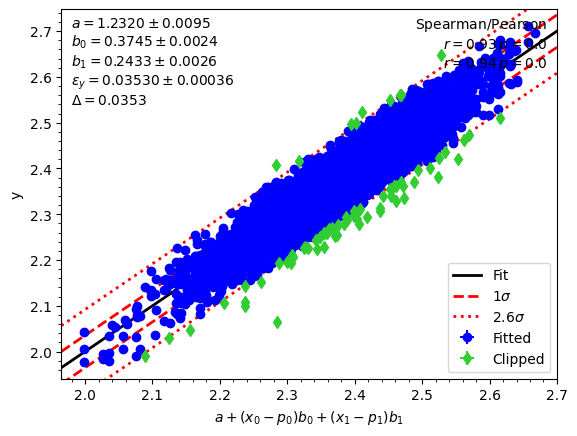

In [23]:
x1 = np.log10(GGL_data_table["R_e_kpc"])
x2 = np.log10(GGL_data_table["Sigma_half_Msun/pc2"])
y = np.log10(GGL_data_table["sigma_v_D"])

#arrays
x1, x2, y = np.array(x1), np.array(x2), np.array(y)

x = np.column_stack([x1, x2])
sigx = np.ones_like(x)*0.0000001
sigy = np.ones_like(y)*0.0000001  # Example uncertainty for y

p = ltsfit(x, y, sigx, sigy, corr=True, epsy=True, clip = 2.6,
           frac=None, label='Fitted',
           legend=True,plot=True, text=True)

print(f"Best fitting parameters: {p.coef}")
print(f"Scatter in log sigma_v: {p.sig_int} dex")
print(f"Scatter in sigma_v: {p.sig_int*np.log(10)*100:.2f} %")


In [17]:
# make bins on the R_e vs Sigma_half plane and make pairings
# then compute the scatter in sigma_v_D from pairings
# and also the scatter in beta_E from pairings

num_bins = 20  # number of bins


# define a cosmology
cosmology = "FwCDM"  # Flat wCDM cosmology
# other options are: "FLCDM FwCDM", "w0waCDM", "oLCDM"
kwargs_cosmo_true = {"h0": 70, "om": 0.3, "w": -1}  # cosmological model of the forecast

# create astropy.cosmology instance of input cosmology
cosmo_param = CosmoParam(cosmology=cosmology)
cosmo_true = cosmo_param.cosmo(kwargs_cosmo_true)

# binned statistics
binned_statistics = {
    'num_pairs': np.zeros((num_bins - 1, num_bins - 1)),
    'rel_scatter_beta_E': np.ones((num_bins - 1, num_bins - 1))*np.nan,
    'rel_scatter_sigma_v_D': np.ones((num_bins - 1, num_bins - 1))*np.nan,
}
THRESHOLD_DELTA_Z = 0.01  # threshold for delta_z to consider a pair valid

# store pairing data template 
individual_pair_data = {
    'beta_E_pseudo': [],
    'beta_E_DSPL': [],
    'z_D1': [],
    'z_D2': [],
    'z_S1': [],
    'z_S2': [],
    'sigma_v_D1': [],
    'sigma_v_D2': [],
    'lens1_id': [],
    'lens2_id': [],
}

# make bins on the R_e vs Sigma_half plane
x = np.log10(GGL_data_table["R_e_kpc"])
y = np.log10(GGL_data_table["Sigma_half_Msun/pc2"])

x_bins = np.linspace(np.nanmin(x), np.nanmax(x), num_bins)
y_bins = np.linspace(np.nanmin(y), np.nanmax(y), num_bins)

# make pairings
for i in tqdm(range(len(x_bins) - 1)):
    for j in range(len(y_bins) - 1):
        mask = (
            (x >= x_bins[i]) & (x < x_bins[i + 1]) &
            (y >= y_bins[j]) & (y < y_bins[j + 1])
        )
        if np.sum(mask) < 2:
            continue
        
        # get the data points in this bin
        data_points = GGL_data_table[mask]
        
        curr_bin_sig_v_D1s = []
        curr_bin_sig_v_D2s = []
        curr_bin_beta_E_pseudos = []
        curr_bin_beta_E_DSPLs = []
        curr_bin_num_pairs = 0


        # make pairings
        for lens1, lens2 in combinations(data_points, 2):
            beta_E_pseudo = lens1['theta_E'] / lens2['theta_E']

            # check z_lens < z_source
            if lens1['z_D'] >= lens2['z_S'] or lens2['z_D'] >= lens1['z_S']:
                continue

            beta_DSPL = beta_double_source_plane(
                z_lens = np.mean([lens1['z_D'], lens2['z_D']]),
                z_source_1= lens1['z_S'],
                z_source_2= lens2['z_S'],
                cosmo = cosmo_true,
            )
            beta_E_DSPL = beta2theta_e_ratio(
                beta_dsp= beta_DSPL,
                gamma_pl= 2, #TODO: what if gamma_pl != 2?
                lambda_mst= 1
            )

            individual_pair_data['beta_E_pseudo'].append(beta_E_pseudo)
            individual_pair_data['beta_E_DSPL'].append(beta_E_DSPL)
            individual_pair_data['z_D1'].append(lens1['z_D'])
            individual_pair_data['z_D2'].append(lens2['z_D'])
            individual_pair_data['z_S1'].append(lens1['z_S'])
            individual_pair_data['z_S2'].append(lens2['z_S'])
            individual_pair_data['sigma_v_D1'].append(lens1['sigma_v_D'])
            individual_pair_data['sigma_v_D2'].append(lens2['sigma_v_D'])
            individual_pair_data['lens1_id'].append(lens1['lens_id'])
            individual_pair_data['lens2_id'].append(lens2['lens_id'])

            if 2*np.abs(lens1['z_D'] - lens2['z_D'])/(lens1['z_D'] + lens2['z_D']) <= THRESHOLD_DELTA_Z:
                curr_bin_sig_v_D1s.append(lens1['sigma_v_D'])
                curr_bin_sig_v_D2s.append(lens2['sigma_v_D'])
                curr_bin_beta_E_pseudos.append(beta_E_pseudo)
                curr_bin_beta_E_DSPLs.append(beta_E_DSPL)
                curr_bin_num_pairs += 1
        
        # make numpy arrays
        curr_bin_sig_v_D1s = np.array(curr_bin_sig_v_D1s)
        curr_bin_sig_v_D2s = np.array(curr_bin_sig_v_D2s)
        curr_bin_beta_E_pseudos = np.array(curr_bin_beta_E_pseudos)
        curr_bin_beta_E_DSPLs = np.array(curr_bin_beta_E_DSPLs)

        # compute the relative scatter in beta_E and sigma_v_D
        if len(curr_bin_sig_v_D1s) > 0 and len(curr_bin_sig_v_D2s) > 0:
            # relative scatter in beta_E
            rel_scatter_beta_E = np.std(1 - curr_bin_beta_E_pseudos/curr_bin_beta_E_DSPLs)
            binned_statistics['rel_scatter_beta_E'][i, j] = rel_scatter_beta_E

            # relative scatter in sigma_v_D
            rel_scatter_sigma_v_D = 2 * np.std(curr_bin_sig_v_D1s - curr_bin_sig_v_D2s)/ np.mean(curr_bin_sig_v_D1s + curr_bin_sig_v_D2s)
            binned_statistics['rel_scatter_sigma_v_D'][i, j] = rel_scatter_sigma_v_D

            # update the number of pairs in this bin
            binned_statistics['num_pairs'][i, j] = curr_bin_num_pairs

# convert to astropy tables
individual_pair_data_table = Table(individual_pair_data)

individual_pair_data_table

100%|██████████| 19/19 [00:13<00:00,  1.38it/s]


beta_E_pseudo,beta_E_DSPL,z_D1,z_D2,z_S1,z_S2,sigma_v_D1,sigma_v_D2,lens1_id,lens2_id
float64,float64,float64,float64,float64,float64,float64,float64,int64,int64
0.8934850026359854,1.1234834340542355,0.3508366197875022,0.3620911023550497,3.5838671355393195,1.7526678621306748,149.81556404690141,168.79967282267145,663,1418
0.8048168142112336,1.0111262139766422,0.3508366197875022,0.2846013599191938,3.5838671355393195,3.201849663926679,149.81556404690141,164.24668357195608,663,3012
0.9903121268093775,0.9938067901518245,0.3508366197875022,0.37073778203290075,3.5838671355393195,3.8059796611498817,149.81556404690141,151.04078711936415,663,3799
0.9007614138310545,0.9118133772707815,0.3620911023550497,0.2846013599191938,1.7526678621306748,3.201849663926679,168.79967282267145,164.24668357195608,1418,3012
1.1083701728487103,0.8809933674942495,0.3620911023550497,0.37073778203290075,1.7526678621306748,3.8059796611498817,168.79967282267145,151.04078711936415,1418,3799
1.2304814080952569,0.9831146493757266,0.2846013599191938,0.37073778203290075,3.201849663926679,3.8059796611498817,164.24668357195608,151.04078711936415,3012,3799
0.865149177037603,1.081372879450264,0.11452865256521456,0.11481755505949663,4.6151024398779095,1.1155260007130066,141.29420849032388,157.9885526264794,576,3094
0.8736094855282596,1.0140883516902761,0.11452865256521456,0.11963325158125679,4.6151024398779095,2.9363488978002947,141.29420849032388,152.4781458972197,576,3569
1.009779016977888,0.9360309186611583,0.11481755505949663,0.11963325158125679,1.1155260007130066,2.9363488978002947,157.9885526264794,152.4781458972197,3094,3569


In [18]:
# print the scatter in sigma_v_D for pairs with |z_D1 - z_D2| < 0.01
print(f"================= Sky Area: {sky_area} sq. deg. =================")
mask = np.abs(individual_pair_data_table['z_D1'] - individual_pair_data_table['z_D2']) < 0.01
print(f"# of pairs with |Δz/z| < 0.01: {np.sum(mask)}")
sigma_v_scatter = np.std(individual_pair_data_table[mask]['sigma_v_D1'] - individual_pair_data_table[mask]['sigma_v_D2']) / (np.mean(individual_pair_data_table[mask]['sigma_v_D1'] + individual_pair_data_table[mask]['sigma_v_D2']) / 2)
print(f"Relative scatter in σᵥ: {sigma_v_scatter:.3f}")

# scatter in beta_E
beta_E_scatter = np.std(1 - individual_pair_data_table[mask]['beta_E_pseudo']/individual_pair_data_table[mask]['beta_E_DSPL'])
print(f"Relative scatter in β_E: {beta_E_scatter:.3f}")
print()  # for better readability

================= Sky Area: 50.0v2 sq. deg. =================
# of pairs with |Δz/z| < 0.01: 5751
Relative scatter in σᵥ: 0.080
Relative scatter in β_E: 0.162



Text(0, 0.5, '$\\Delta \\sigma_v / \\sigma_v$ of MFP (%)')

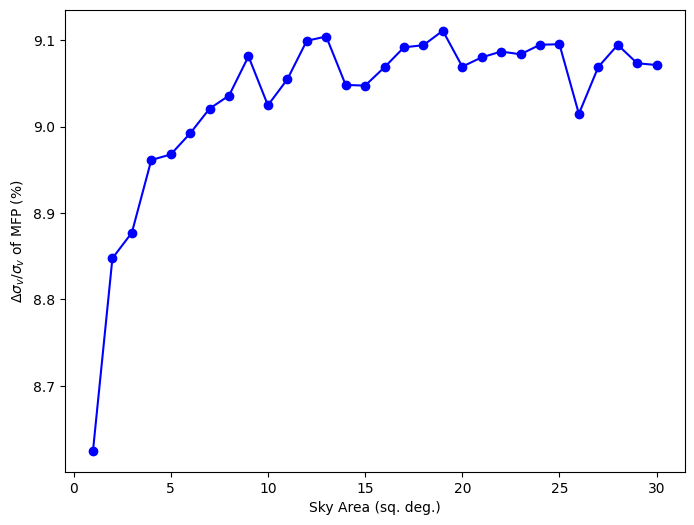

In [37]:
# scatter in sigma_v_D on MFP vs sky area

areas = np.arange(1, 31)  # sky areas from 1 to 30 sq. deg.
sigma_v_scatter_MFP = []
for area in areas:
    # randomly sample scaled number of lenses
    num_lenses = (area/int(sky_area.split('.')[0])) * len(GGL_data_table)
    num_lenses = int(num_lenses)  # ensure it's an integer
    
    sigma_v_scatter = 0
    for _ in range(100):  # repeat the sampling 100 times to get a better estimate
        # sample the data points
        sampled_data = GGL_data_table[np.random.choice(len(GGL_data_table), num_lenses, replace=False)]
        # fit the MFP
        coeffs_MFP = fit_plane(
            np.log10(sampled_data["R_e_kpc"]),
            np.log10(sampled_data["Sigma_half_Msun/pc2"]),
            np.log10(sampled_data["sigma_v_D"])
        )
        # find the scatter
        scatter_MFP = find_scatter(
            np.log10(sampled_data["R_e_kpc"]),
            np.log10(sampled_data["Sigma_half_Msun/pc2"]),
            np.log10(sampled_data["sigma_v_D"]),
            coeffs_MFP,
            return_fit=False
        )
        # compute the relative scatter
        sigma_v_scatter += np.std(scatter_MFP) * np.log(10)

    sigma_v_scatter /= 100  # average over 100 samples
    sigma_v_scatter_MFP.append(sigma_v_scatter)

sigma_v_scatter_MFP = np.array(sigma_v_scatter_MFP)

# plot the scatter in sigma_v_D vs sky area
plt.figure(figsize=(8, 6))
plt.plot(areas, sigma_v_scatter_MFP*100, marker='o', linestyle='-',
         color='blue', label='σᵥ scatter on MFP')
plt.xlabel('Sky Area (sq. deg.)')
plt.ylabel('$\\Delta \\sigma_v / \\sigma_v$ of MFP (%)')

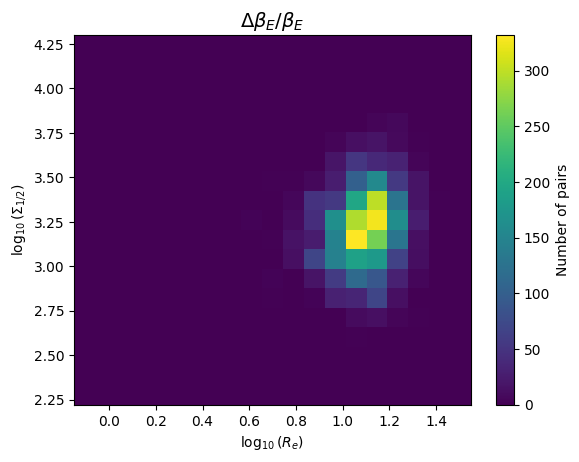

In [19]:
# number of pairs within bins
plt.figure()
# Second plot: binned_statistics['rel_scatter_beta_E']
im2 = plt.imshow(binned_statistics['num_pairs'], origin='lower', aspect='auto', cmap='viridis',
  extent=[
    np.nanmin(x_bins), np.nanmax(x_bins),
    np.nanmin(y_bins), np.nanmax(y_bins)
  ])
plt.xlabel('$\\log_{10}(R_e)$')
plt.ylabel('$\\log_{10}(\\Sigma_{1/2})$')
plt.title('${\\Delta \\beta_E}/{\\beta_E}$', fontsize= 14)

plt.colorbar(im2, label='Number of pairs')

## Plots for Paper

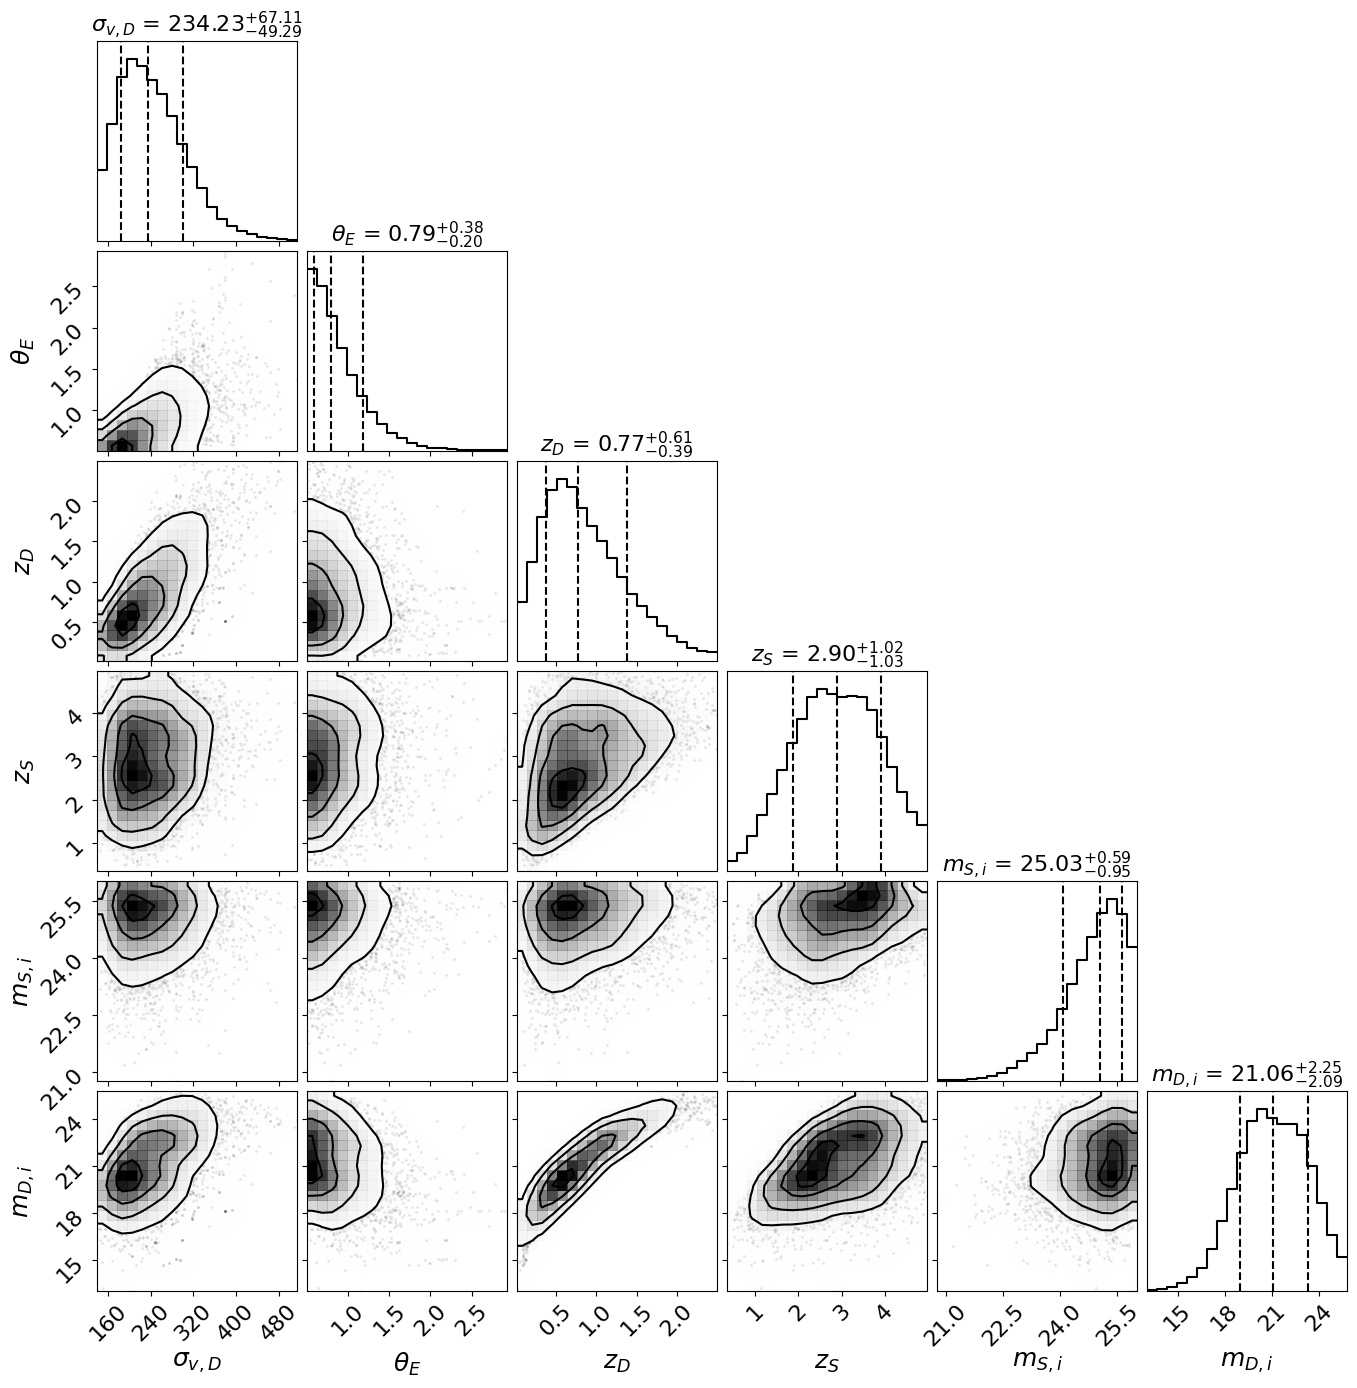

In [39]:
### Corner plot of lens properties

keys = [
    'sigma_v_D',
    'theta_E',
    'z_D',
    'z_S',
    'mag_S_i',
    'mag_D_i',
    # 'e_mass_D',
]

latex_keys = [
    r"$\sigma_{v,D}$",
    r"$\theta_{E}$",
    r"$z_{D}$",
    r"$z_{S}$",
    r"$m_{S,i}$",
    r"$m_{D,i}$",
    # r"$\varepsilon_{D}$",
]

corner_data = GGL_data_table[keys]
corner_data = np.array([corner_data[key] for key in keys]).T

# make a corner plot
fig = corner.corner(
    corner_data,
    labels=latex_keys,
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    smooth=True,
    smooth1d=True,
)

# make tick and label sizes larger
for ax in fig.get_axes():
    ax.tick_params(labelsize=16)
    ax.xaxis.label.set_size(18)
    ax.yaxis.label.set_size(18)

    # make title font size larger
    ax.title.set_fontsize(16)

# save the figure
fig.savefig(f"../figures/slsim_corner_GGL.pdf", bbox_inches='tight', dpi=300)

(0.2, 1.3)

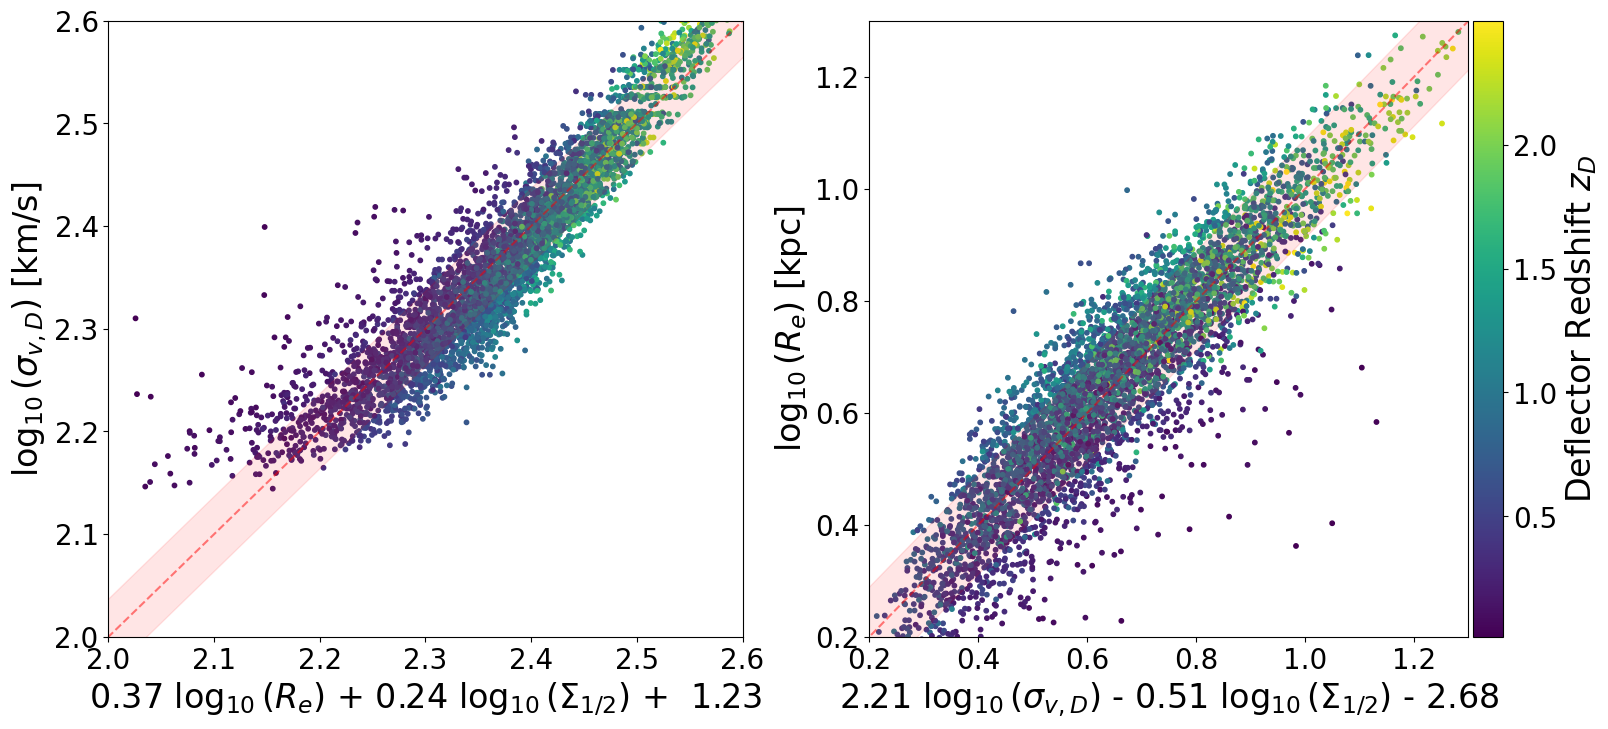

In [27]:
## MFP plot

# side-by-side plot of the two fundamental planes
fig, axs = plt.subplots(1, 2, figsize=(18, 8))

# sigma_v fundamental plane
axs[0].scatter(
    coeffs_MFP[0] * np.log10(GGL_data_table["R_e_kpc"]) + 
    coeffs_MFP[1] * np.log10(GGL_data_table["Sigma_half_Msun/pc2"]) + 
    coeffs_MFP[2],
    np.log10(GGL_data_table["sigma_v_D"]),
    c=GGL_data_table["z_D"], s=10, label='SLSim MFP', 
    cmap='viridis'
)
axs[0].set_xlabel(f'{coeffs_MFP[0]:.2f} ' + r'$\log_{10}(R_e)$ + ' + f'{coeffs_MFP[1]:.2f} ' + r'$\log_{10}(\Sigma_{1/2})$ + ' + f' {coeffs_MFP[2]:.2f}')
axs[0].set_ylabel(r'$\log_{10}(\sigma_{v, D})$ [km/s]')
# axs[0].set_title('SLSim Mass Fundamental Plane', fontsize=16)

# Plot the fitted plane with a faded scatter
# y = x
axs[0].plot([axs[0].get_xlim()[0], axs[0].get_xlim()[1]],
            [axs[0].get_xlim()[0], axs[0].get_xlim()[1]],
            color='red', linestyle='--', alpha=0.5, label='y = x')
# faded region for the scatter
x_faded = np.linspace(axs[0].get_xlim()[0], axs[0].get_xlim()[1], 100)
y_faded = x_faded
axs[0].fill_between(x_faded, y_faded - np.std(scatter_MFP),
                    y_faded + np.std(scatter_MFP), color='red', alpha=0.1)

# R_e fundamental plane
scatter_plot = axs[1].scatter(
    coeffs_MFP_alt[0] * np.log10(GGL_data_table["sigma_v_D"]) + 
    coeffs_MFP_alt[1] * np.log10(GGL_data_table["Sigma_half_Msun/pc2"]) + 
    coeffs_MFP_alt[2],
    np.log10(GGL_data_table["R_e_kpc"]),
    c=GGL_data_table["z_D"], s=10, label='SLSim MFP', 
    cmap='viridis'
)
axs[1].set_xlabel(f'{coeffs_MFP_alt[0]:.2f} ' + r'$\log_{10}(\sigma_{v, D})$ ' + f'{'+' if coeffs_MFP_alt[1] > 0 else '-'} {np.abs(coeffs_MFP_alt[1]):.2f} ' + r'$\log_{10}(\Sigma_{1/2})$ ' + f'{'+' if coeffs_MFP_alt[2] > 0 else '-'} {np.abs(coeffs_MFP_alt[2]):.2f}')
axs[1].set_ylabel(r'$\log_{10}(R_e)$ [kpc]')
# axs[1].set_title('SLSim Mass Fundamental Plane', fontsize=16)
# Plot the fitted plane with a faded scatter
# y = x
axs[1].plot([axs[1].get_xlim()[0], axs[1].get_xlim()[1]],
            [axs[1].get_xlim()[0], axs[1].get_xlim()[1]],
            color='red', linestyle='--', alpha=0.5, label='y = x')
# faded region for the scatter
x_faded = np.linspace(axs[1].get_xlim()[0], axs[1].get_xlim()[1], 100)
y_faded = x_faded
axs[1].fill_between(x_faded, y_faded - np.std(scatter_MFP_alt),
                    y_faded + np.std(scatter_MFP_alt), color='red', alpha=0.1)

# common colorbar
divider = make_axes_locatable(axs[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(scatter_plot, cax=cax)
cbar.set_label('Deflector Redshift $z_D$', fontsize=14)


# increase the font size of the labels and title
for ax in axs:
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.set_xlabel(ax.get_xlabel(), fontsize=24)
    ax.set_ylabel(ax.get_ylabel(), fontsize=24)
    ax.set_title(ax.get_title(), fontsize=24)
    # ax.legend(fontsize=14)

# cbar label size
cbar.ax.set_ylabel(cbar.ax.get_ylabel(), fontsize=24)

# cbar tick labels
cbar.ax.tick_params(labelsize=20)

axs[0].set_xlim(2, 2.6)
axs[0].set_ylim(2, 2.6)
axs[1].set_xlim(0.2, 1.3)
axs[1].set_ylim(0.2, 1.3)

# save the figure
# fig.savefig(f"../figures/slsim_MFP.pdf", bbox_inches='tight', dpi=300)

Correlation Coefficient: 0.99, Slope: 2.09, Intercept: -0.00, Standard Error: 0.03

Percentage scatter in y: 9.81%

95% Confidence Interval for the Slope: [2.04, 2.15]

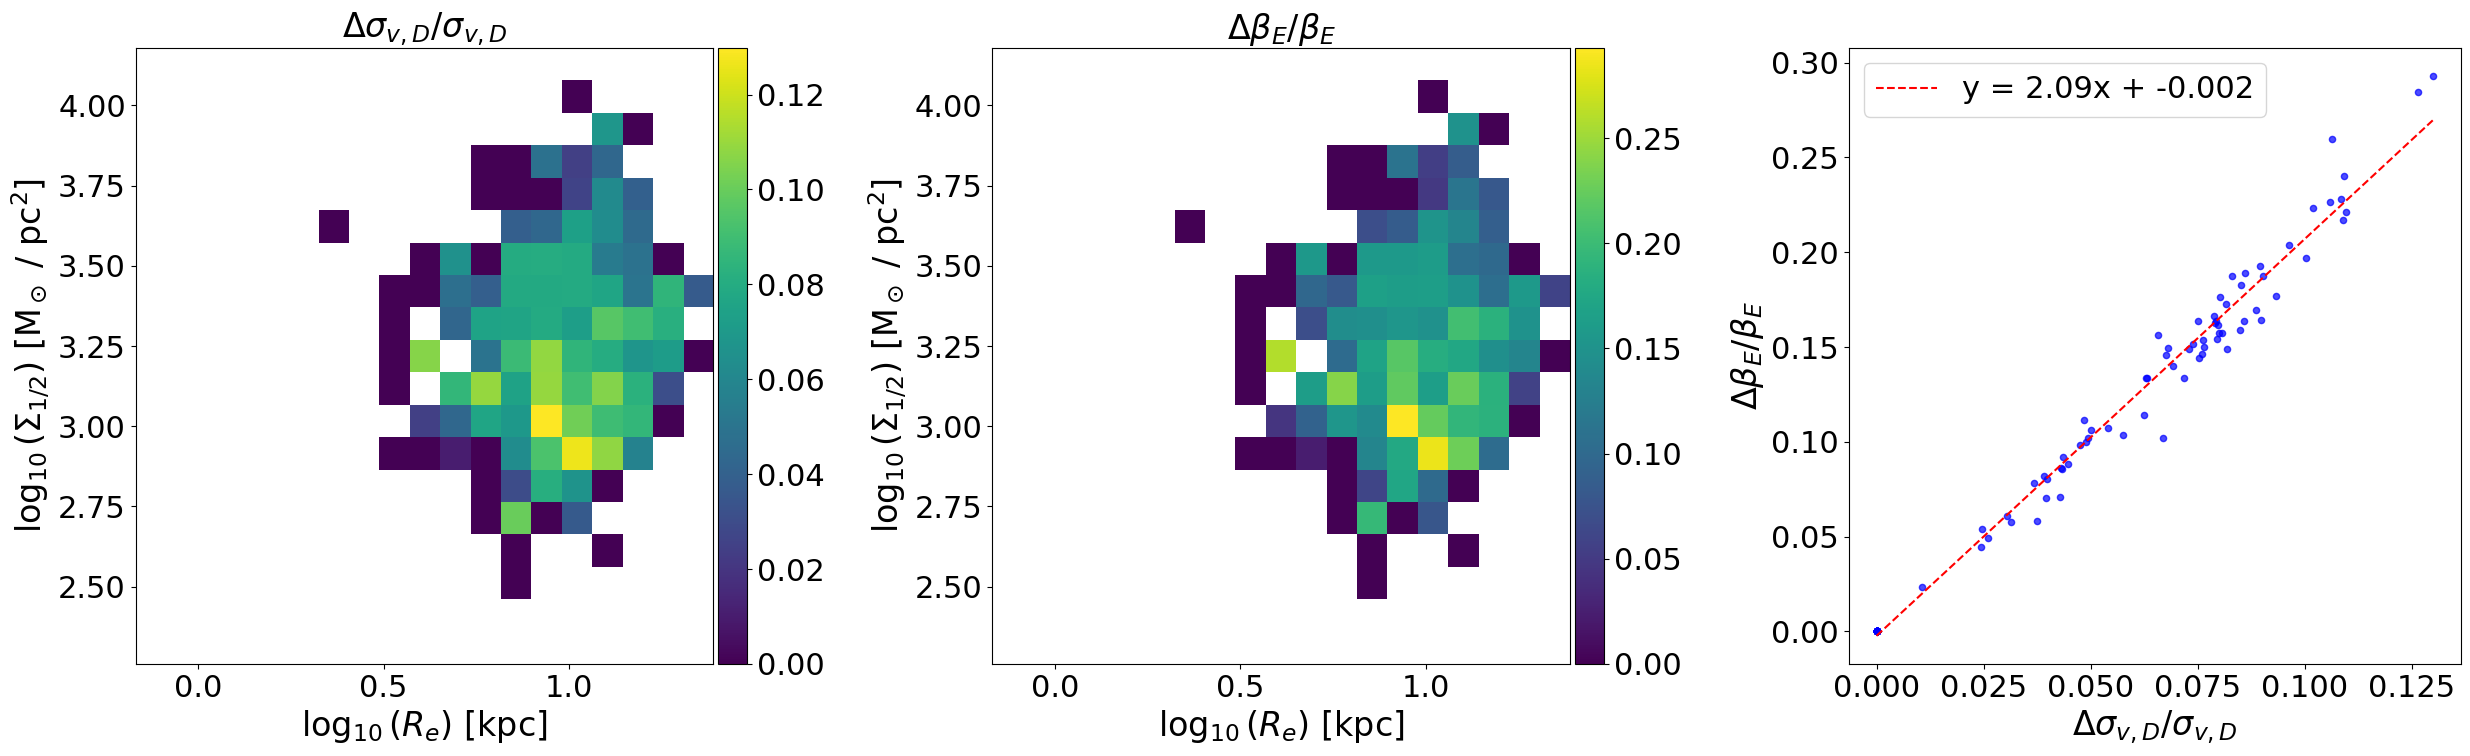

In [53]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, axs = plt.subplots(1, 3, figsize=(30, 8))

base_fontsize = 22

x_label = r'$\log_{10}(R_e)$ [kpc]'
y_label = r'$\log_{10}(\Sigma_{1/2})$ [M$_\odot$ / pc$^2$]'

# First plot: binned_statistics['rel_scatter_sigma_v_D']
im1 = axs[0].imshow(binned_statistics['rel_scatter_sigma_v_D'], origin='lower', aspect='auto', cmap='viridis',
  extent=[
    np.nanmin(x_bins), np.nanmax(x_bins),
    np.nanmin(y_bins), np.nanmax(y_bins)
  ])
axs[0].set_xlabel(x_label)
axs[0].set_ylabel(y_label)
axs[0].set_title(r'${\Delta \sigma_{v,D}}/{\sigma_{v,D}}$', fontsize=base_fontsize+2)

# Second plot: binned_statistics['rel_scatter_beta_E']
im2 = axs[1].imshow(binned_statistics['rel_scatter_beta_E'], origin='lower', aspect='auto', cmap='viridis',
  extent=[
    np.nanmin(x_bins), np.nanmax(x_bins),
    np.nanmin(y_bins), np.nanmax(y_bins)
  ])
axs[1].set_xlabel(x_label)
axs[1].set_ylabel(y_label)
axs[1].set_title(r'${\Delta \beta_E}/{\beta_E}$', fontsize=base_fontsize+2)

# Third plot: scatter plot between the two quantities
axs[2].scatter(binned_statistics['rel_scatter_sigma_v_D'].flatten(),
    binned_statistics['rel_scatter_beta_E'].flatten(),
    s=20, alpha=0.7, c='blue')
axs[2].set_xlabel(r'${\Delta \sigma_{v,D}}/{\sigma_{v,D}}$', fontsize=20)
axs[2].set_ylabel(r'${\Delta \beta_E}/{\beta_E}$', fontsize=20)

# Fit and plot line for the scatter plot
x_scatter = binned_statistics['rel_scatter_sigma_v_D'].flatten()
y_scatter = binned_statistics['rel_scatter_beta_E'].flatten()
mask = ~np.isnan(x_scatter) & ~np.isnan(y_scatter)
x_scatter = x_scatter[mask]
y_scatter = y_scatter[mask]
coeffs = np.polyfit(x_scatter, y_scatter, 1)
x_fit = np.linspace(np.nanmin(x_scatter), np.nanmax(x_scatter), 100)
y_fit = coeffs[0] * x_fit + coeffs[1]
axs[2].plot(x_fit, y_fit, color='red', linestyle='--', 
  label=f'y = {coeffs[0]:.2f}x + {coeffs[1]:.3f}')
axs[2].legend(fontsize=base_fontsize)

# Create separate axes for colorbars that take up the extra space

# Create colorbars with larger size to take up extra space
divider1 = make_axes_locatable(axs[0])
cax1 = divider1.append_axes("right", size="5%", pad=0.05)
cbar1 = plt.colorbar(im1, cax=cax1)

divider2 = make_axes_locatable(axs[1])
cax2 = divider2.append_axes("right", size="5%", pad=0.05)
cbar2 = plt.colorbar(im2, cax=cax2)

# Apply consistent styling
for ax in axs:
  ax.tick_params(axis='both', which='major', labelsize=base_fontsize)
  ax.set_xlabel(ax.get_xlabel(), fontsize=base_fontsize+2)
  ax.set_ylabel(ax.get_ylabel(), fontsize=base_fontsize+2)
  ax.set_title(ax.get_title(), fontsize=base_fontsize+2)

# Style colorbars
cbar1.ax.tick_params(labelsize=base_fontsize)
cbar2.ax.tick_params(labelsize=base_fontsize)

# Adjust the subplot widths to make them similar
plt.subplots_adjust(wspace=0.4)

# Save the figure
# fig.savefig(f"../figures/slsim_scatter_rel_sigma_v_beta_E.pdf", bbox_inches='tight', dpi=300)

# Correlation Coefficient and Scatter in Linear Regression
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(
    x_scatter, y_scatter
)
display(Markdown(f"Correlation Coefficient: {r_value:.2f}, Slope: {slope:.2f}, Intercept: {intercept:.2f}, Standard Error: {std_err:.2f}"))
display(Markdown(f"Percentage scatter in y: {np.std(y_scatter - (slope * x_scatter + intercept)) / np.mean(y_scatter) * 100:.2f}%"))


# 95% confidence interval for the slope
from scipy.stats import t
n = len(x_scatter)  # number of data points
alpha = 0.05  # significance level for 95% confidence interval
t_critical = t.ppf(1 - alpha/2, n - 2)
margin_of_error = t_critical * std_err
lower_bound = slope - margin_of_error
upper_bound = slope + margin_of_error
display(Markdown(f"95% Confidence Interval for the Slope: [{lower_bound:.2f}, {upper_bound:.2f}]"))

Correlation Coefficient: 0.98, Slope: 1.99, Intercept: 0.00, Standard Error: 0.06

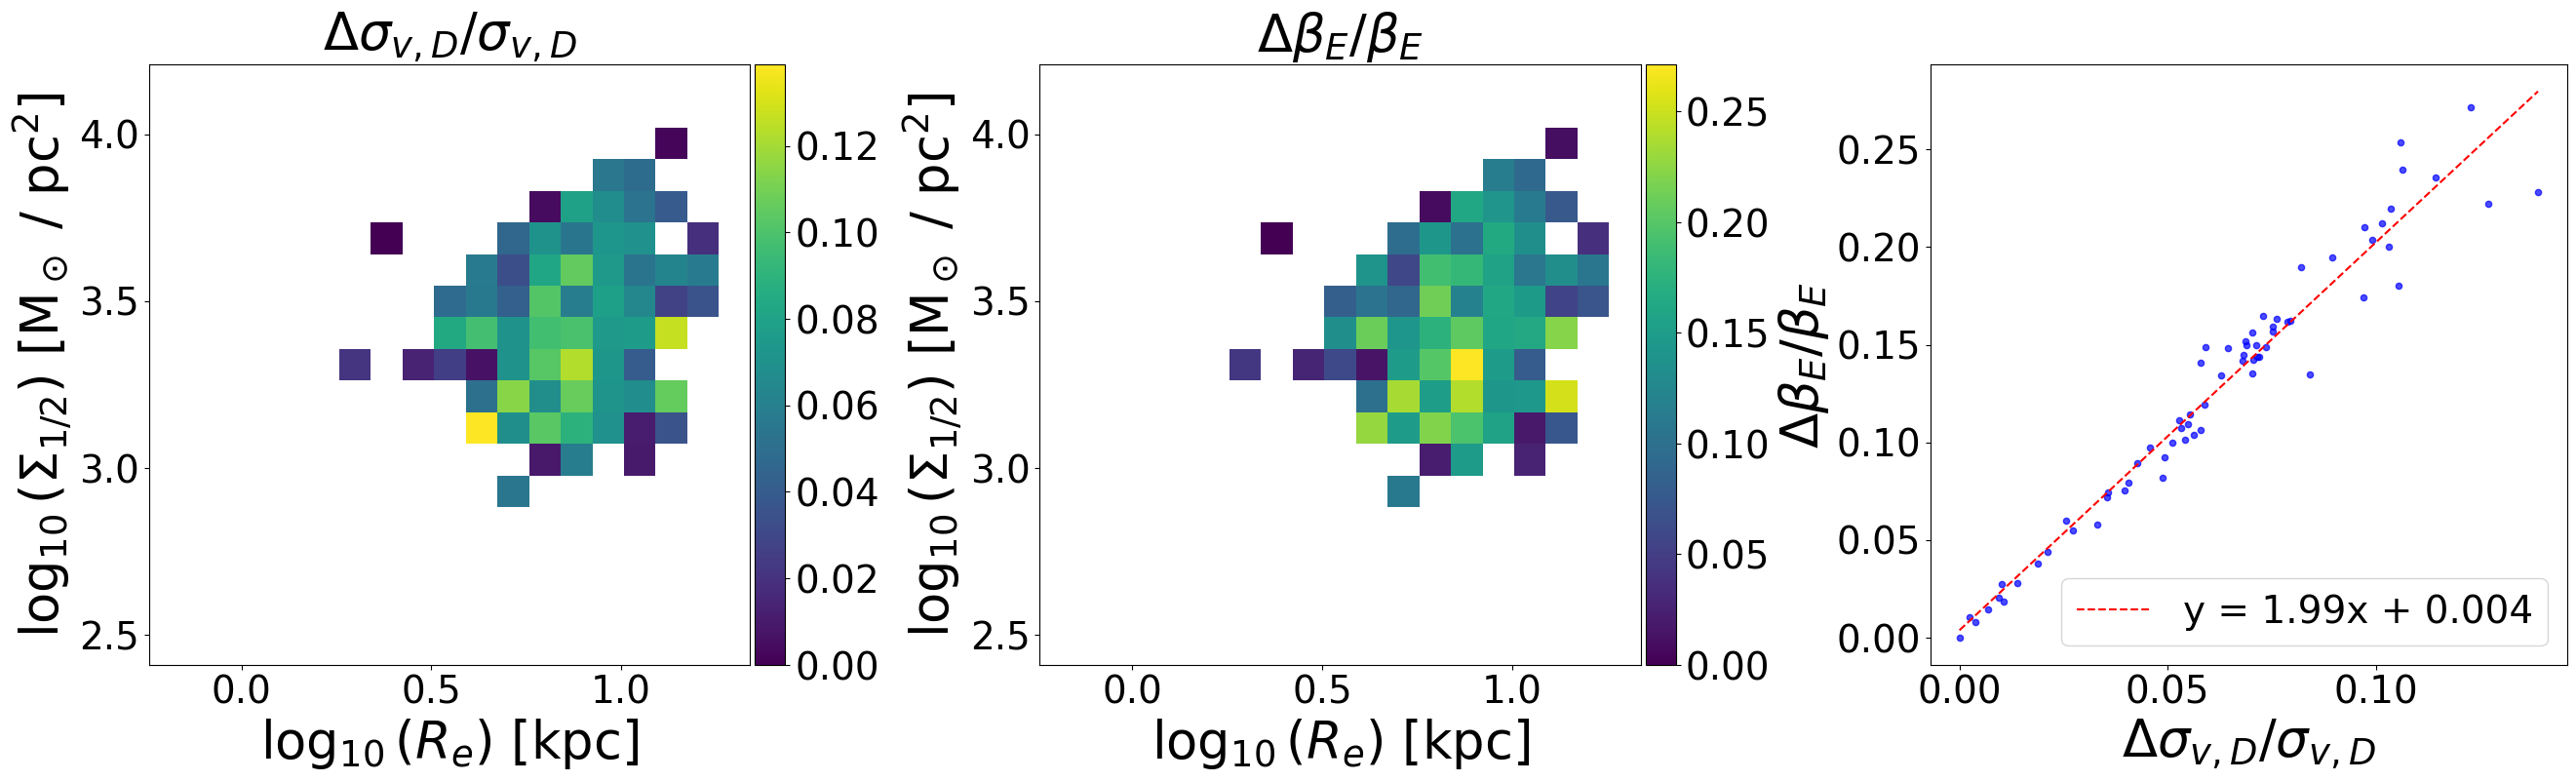

In [51]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, axs = plt.subplots(1, 3, figsize=(32, 8))

base_fontsize = 28

x_label = r'$\log_{10}(R_e)$ [kpc]'
y_label = r'$\log_{10}(\Sigma_{1/2})$ [M$_\odot$ / pc$^2$]'

mask = binned_statistics['num_pairs'] > 1

# First plot: rel_scatter_sigma_v_D
rel_scatter_sigma_v_D = binned_statistics['rel_scatter_sigma_v_D'].copy()
rel_scatter_sigma_v_D[~mask] = np.nan  # set to NaN

# Second plot: rel_scatter_beta_E
rel_scatter_beta_E = binned_statistics['rel_scatter_beta_E'].copy()
rel_scatter_beta_E[~mask] = np.nan  # set to NaN



# First plot: rel_scatter_sigma_v_D
im1 = axs[0].imshow(rel_scatter_sigma_v_D, origin='lower', aspect='auto', cmap='viridis',
  extent=[
    np.nanmin(x_bins), np.nanmax(x_bins),
    np.nanmin(y_bins), np.nanmax(y_bins)
  ])
axs[0].set_xlabel(x_label)
axs[0].set_ylabel(y_label)
axs[0].set_title(r'${\Delta \sigma_{v,D}}/{\sigma_{v,D}}$', fontsize=base_fontsize+2)

# Second plot: rel_scatter_beta_E
im2 = axs[1].imshow(rel_scatter_beta_E, origin='lower', aspect='auto', cmap='viridis',
  extent=[
    np.nanmin(x_bins), np.nanmax(x_bins),
    np.nanmin(y_bins), np.nanmax(y_bins)
  ])
axs[1].set_xlabel(x_label)
axs[1].set_ylabel(y_label)
axs[1].set_title(r'${\Delta \beta_E}/{\beta_E}$', fontsize=base_fontsize+2)

# Third plot: scatter plot between the two quantities
axs[2].scatter(rel_scatter_sigma_v_D.flatten(),
    rel_scatter_beta_E.flatten(),
    s=20, alpha=0.7, c='blue')
axs[2].set_xlabel(r'${\Delta \sigma_{v,D}}/{\sigma_{v,D}}$', fontsize=20)
axs[2].set_ylabel(r'${\Delta \beta_E}/{\beta_E}$', fontsize=20)

# Fit and plot line for the scatter plot
x_scatter = rel_scatter_sigma_v_D.flatten()
y_scatter = rel_scatter_beta_E.flatten()
mask = ~np.isnan(x_scatter) & ~np.isnan(y_scatter)
x_scatter = x_scatter[mask]
y_scatter = y_scatter[mask]
coeffs = np.polyfit(x_scatter, y_scatter, 1)
x_fit = np.linspace(np.nanmin(x_scatter), np.nanmax(x_scatter), 100)
y_fit = coeffs[0] * x_fit + coeffs[1]
axs[2].plot(x_fit, y_fit, color='red', linestyle='--', 
  label=f'y = {coeffs[0]:.2f}x + {coeffs[1]:.3f}')
axs[2].legend(fontsize=base_fontsize)

# Create separate axes for colorbars that take up the extra space

# Create colorbars with larger size to take up extra space
divider1 = make_axes_locatable(axs[0])
cax1 = divider1.append_axes("right", size="5%", pad=0.05)
cbar1 = plt.colorbar(im1, cax=cax1)

divider2 = make_axes_locatable(axs[1])
cax2 = divider2.append_axes("right", size="5%", pad=0.05)
cbar2 = plt.colorbar(im2, cax=cax2)

# Apply consistent styling
for ax in axs:
  ax.tick_params(axis='both', which='major', labelsize=base_fontsize)
  ax.set_xlabel(ax.get_xlabel(), fontsize=base_fontsize+10)
  ax.set_ylabel(ax.get_ylabel(), fontsize=base_fontsize+10)
  ax.set_title(ax.get_title(), fontsize=base_fontsize+10)

# Style colorbars
cbar1.ax.tick_params(labelsize=base_fontsize)
cbar2.ax.tick_params(labelsize=base_fontsize)

# Adjust the subplot widths to make them similar
plt.subplots_adjust(wspace=0.4)
# fig.tight_layout()

# Save the figure
fig.savefig(f"../figures/slsim_scatter_rel_sigma_v_beta_E.pdf", bbox_inches='tight', dpi=300)

# Correlation Coefficient and Scatter in Linear Regression
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(
    x_scatter, y_scatter
)
display(Markdown(f"Correlation Coefficient: {r_value:.2f}, Slope: {slope:.2f}, Intercept: {intercept:.2f}, Standard Error: {std_err:.2f}"))


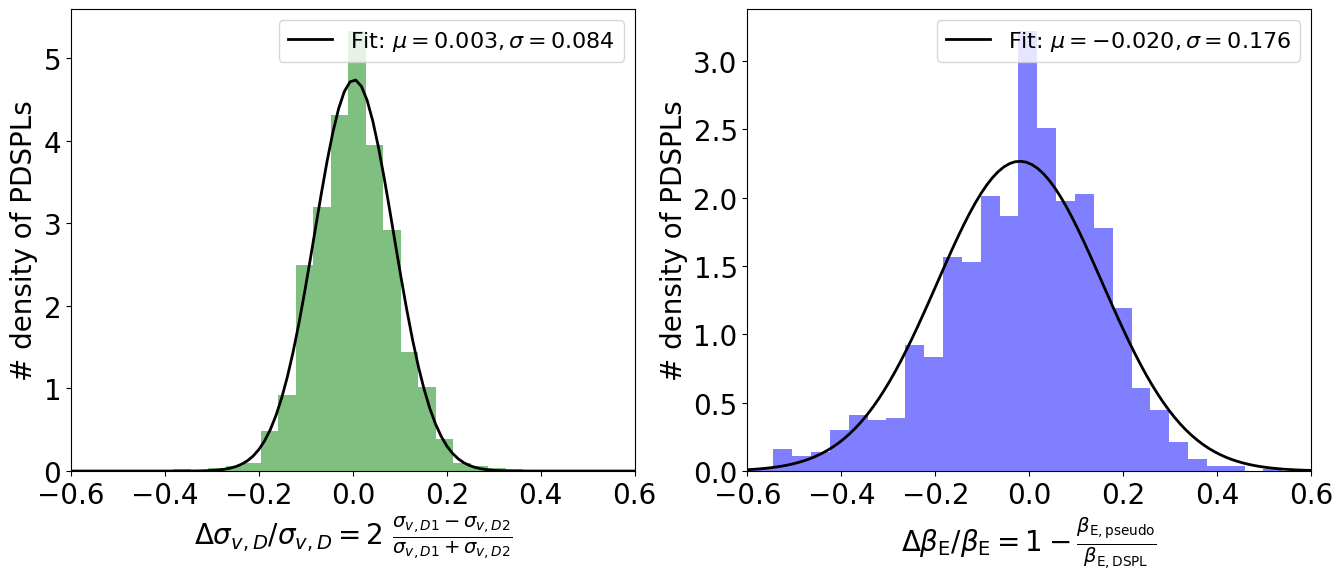

In [62]:
# histogram of the relative scatter in beta_E and sigma_v_D
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

masked_paired_table = individual_pair_data_table[
    np.abs(individual_pair_data_table['z_D1'] - individual_pair_data_table['z_D2']) <= THRESHOLD_DELTA_Z
]

# First histogram: relative scatter in sigma_v_D
axs[0].hist(
    2 * (masked_paired_table['sigma_v_D1'] - masked_paired_table['sigma_v_D2']) / 
    (masked_paired_table['sigma_v_D1'] + masked_paired_table['sigma_v_D2']),
    bins=20, color='green', alpha=0.5, density=True
)
axs[0].set_xlabel(r'$\Delta \sigma_{v,D} / \sigma_{v,D} = 2 \ \frac{\sigma_{v,D1} - \sigma_{v,D2}}{\sigma_{v,D1} + \sigma_{v,D2}}$', fontsize=16)
axs[0].set_ylabel('# density of PDSPLs', fontsize=16)
# axs[0].set_title('Histogram of Relative Scatter in $\\sigma_{v,D}$', fontsize=16)
axs[0].tick_params(axis='both', which='major', labelsize=14)
axs[0].set_xlim(-0.6, 0.6)

# fit a gaussian to the histogram
from scipy.stats import norm
mu, std = norm.fit(
    2 * (masked_paired_table['sigma_v_D1'] - masked_paired_table['sigma_v_D2']) / 
    (masked_paired_table['sigma_v_D1'] + masked_paired_table['sigma_v_D2'])
)
x = np.linspace(-0.6, 0.6, 100)
p = norm.pdf(x, mu, std)
axs[0].plot(x, p, 'k', linewidth=2, label=f'Fit: $\\mu={mu:.3f}, \\sigma={std:.3f}$')
axs[0].legend(fontsize=14)

# Second histogram: relative scatter in beta_E
axs[1].hist(1 - masked_paired_table['beta_E_pseudo'] / masked_paired_table['beta_E_DSPL'], bins=40, 
            color='blue', alpha=0.5, density=True)
axs[1].set_xlabel(r'$\Delta \beta_{\rm E} / \beta_{\rm E} = 1 - \frac{\beta_{\rm E,pseudo}}{\beta_{\rm E,DSPL}}$', fontsize=16)
axs[1].set_ylabel('# density of PDSPLs', fontsize=16)
# axs[1].set_title('Histogram of Relative Scatter in $\\beta_E$', fontsize=16)
axs[1].tick_params(axis='both', which='major', labelsize=14)
axs[1].set_xlim(-0.6, 0.6)

# fit a gaussian to the histogram
mu_beta, std_beta = norm.fit(1 - masked_paired_table['beta_E_pseudo'] / masked_paired_table['beta_E_DSPL'])
x_beta = np.linspace(-0.6, 0.6, 100)
p_beta = norm.pdf(x_beta, mu_beta, std_beta)
axs[1].plot(x_beta, p_beta, 'k', linewidth=2, label=f'Fit: $\\mu={mu_beta:.3f}, \\sigma={std_beta:.3f}$')
axs[1].legend(fontsize=14)

# fig.tight_layout()


# change tick and label sizes
for ax in axs:
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.xaxis.label.set_size(20)
    ax.yaxis.label.set_size(20)
    # make title font size larger
    ax.title.set_fontsize(20)

    # legend font size
    if ax.get_legend() is not None:
        ax.legend(fontsize=16)



fig.savefig(f"../figures/slsim_hists_sigma_v_beta_E.pdf", bbox_inches='tight', dpi=300)

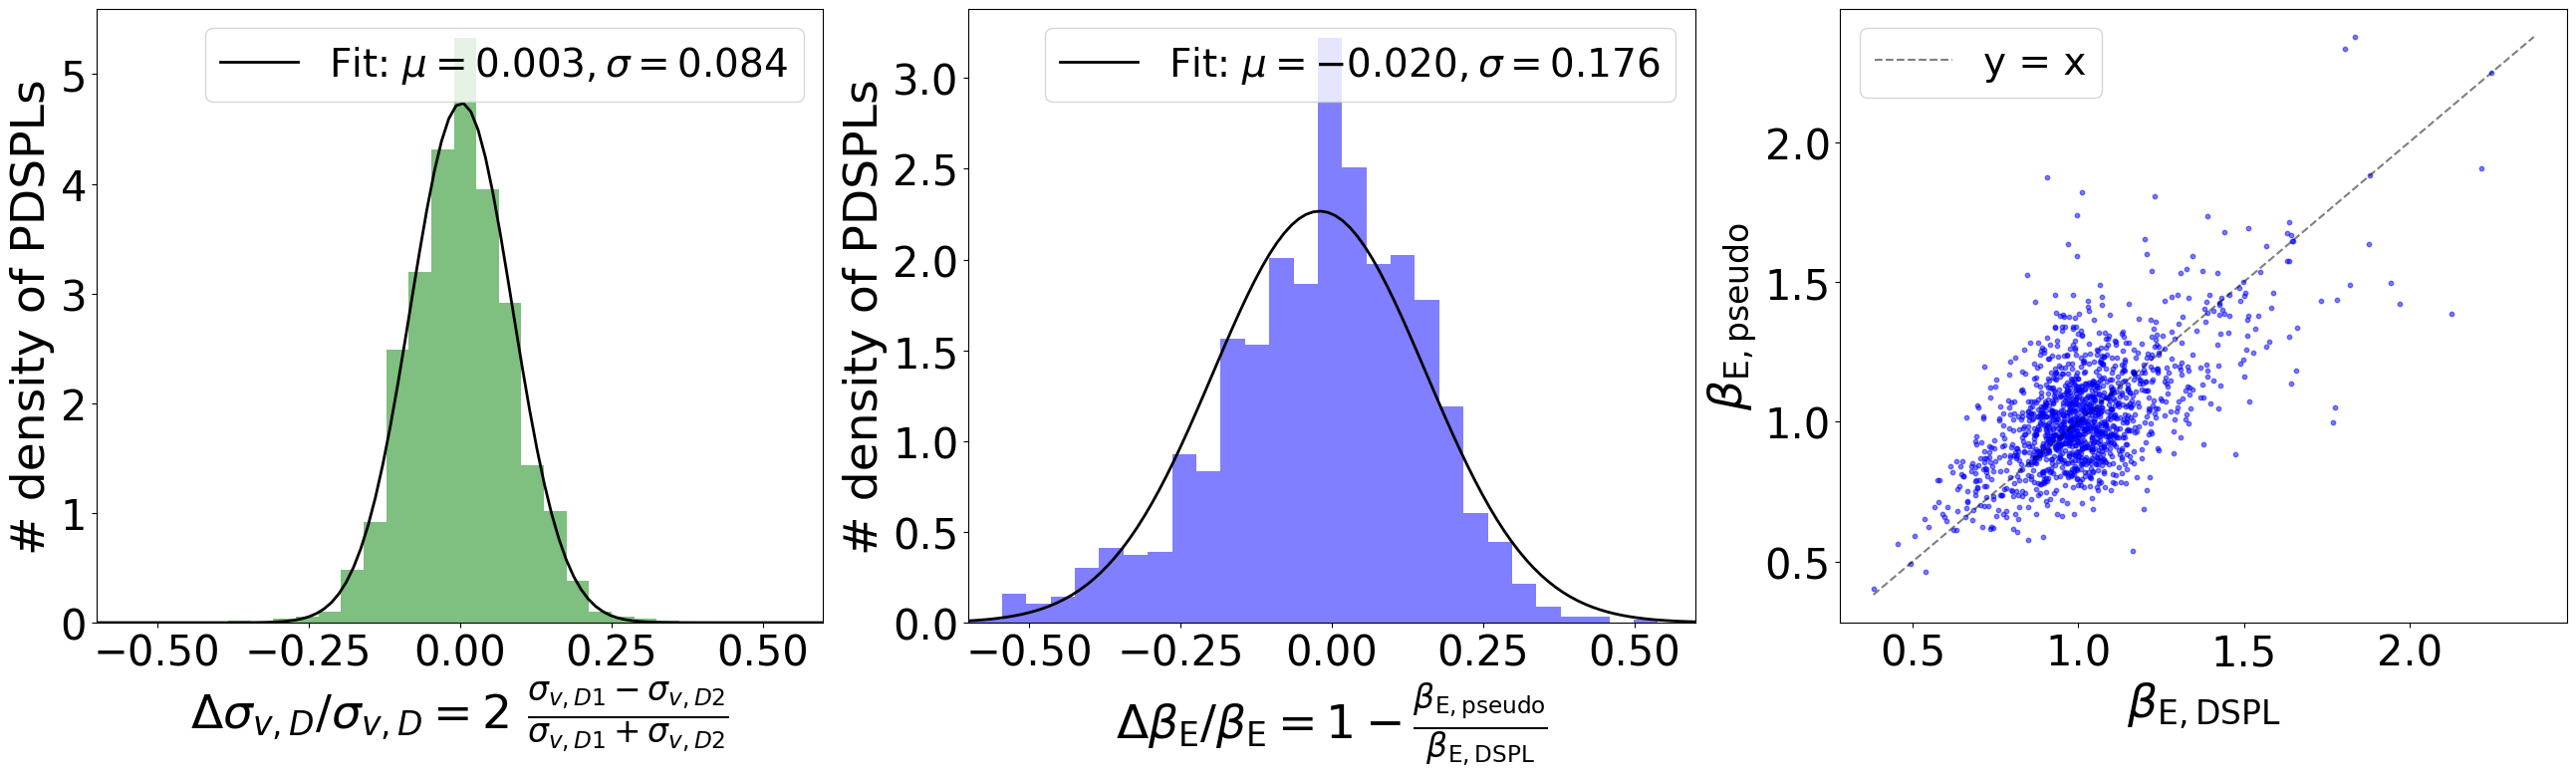

In [74]:
# histogram of the relative scatter in beta_E and sigma_v_D
fig, axs = plt.subplots(1, 3, figsize=(32, 8))

masked_paired_table = individual_pair_data_table[
    np.abs(individual_pair_data_table['z_D1'] - individual_pair_data_table['z_D2']) <= THRESHOLD_DELTA_Z
]

# First histogram: relative scatter in sigma_v_D
axs[0].hist(
    2 * (masked_paired_table['sigma_v_D1'] - masked_paired_table['sigma_v_D2']) / 
    (masked_paired_table['sigma_v_D1'] + masked_paired_table['sigma_v_D2']),
    bins=20, color='green', alpha=0.5, density=True
)
axs[0].set_xlabel(r'$\Delta \sigma_{v,D} / \sigma_{v,D} = 2 \ \frac{\sigma_{v,D1} - \sigma_{v,D2}}{\sigma_{v,D1} + \sigma_{v,D2}}$', fontsize=16)
axs[0].set_ylabel('# density of PDSPLs', fontsize=16)
axs[0].tick_params(axis='both', which='major', labelsize=14)
axs[0].set_xlim(-0.6, 0.6)

# fit a gaussian to the histogram
mu, std = norm.fit(
    2 * (masked_paired_table['sigma_v_D1'] - masked_paired_table['sigma_v_D2']) / 
    (masked_paired_table['sigma_v_D1'] + masked_paired_table['sigma_v_D2'])
)
x = np.linspace(-0.6, 0.6, 100)
p = norm.pdf(x, mu, std)
axs[0].plot(x, p, 'k', linewidth=2, label=f'Fit: $\\mu={mu:.3f}, \\sigma={std:.3f}$')
axs[0].legend(fontsize=14)

# Second histogram: relative scatter in beta_E
axs[1].hist(1 - masked_paired_table['beta_E_pseudo'] / masked_paired_table['beta_E_DSPL'], bins=40, 
            color='blue', alpha=0.5, density=True)
axs[1].set_xlabel(r'$\Delta \beta_{\rm E} / \beta_{\rm E} = 1 - \frac{\beta_{\rm E,pseudo}}{\beta_{\rm E,DSPL}}$', fontsize=16)
axs[1].set_ylabel('# density of PDSPLs', fontsize=16)
axs[1].tick_params(axis='both', which='major', labelsize=14)
axs[1].set_xlim(-0.6, 0.6)

# fit a gaussian to the histogram
mu_beta, std_beta = norm.fit(1 - masked_paired_table['beta_E_pseudo'] / masked_paired_table['beta_E_DSPL'])
x_beta = np.linspace(-0.6, 0.6, 100)
p_beta = norm.pdf(x_beta, mu_beta, std_beta)
axs[1].plot(x_beta, p_beta, 'k', linewidth=2, label=f'Fit: $\\mu={mu_beta:.3f}, \\sigma={std_beta:.3f}$')
axs[1].legend(fontsize=14)

# Third plot: beta_E_pseudo vs beta_E_DSPL
axs[2].scatter(masked_paired_table['beta_E_DSPL'], masked_paired_table['beta_E_pseudo'], 
               alpha=0.5, s=10, color='blue')
axs[2].set_xlabel(r'$\beta_{\rm E,DSPL}$', fontsize=16)
axs[2].set_ylabel(r'$\beta_{\rm E,pseudo}$', fontsize=16)
axs[2].tick_params(axis='both', which='major', labelsize=14)

# Plot y = x line
min_val = min(np.min(masked_paired_table['beta_E_DSPL']), np.min(masked_paired_table['beta_E_pseudo']))
max_val = max(np.max(masked_paired_table['beta_E_DSPL']), np.max(masked_paired_table['beta_E_pseudo']))
axs[2].plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5, label='y = x')
axs[2].legend(fontsize=14)


# change tick and label sizes
for ax in axs:
    ax.tick_params(axis='both', which='major', labelsize=30)
    ax.xaxis.label.set_size(34)
    ax.yaxis.label.set_size(34)
    # make title font size larger
    ax.title.set_fontsize(28)

    # legend font size
    if ax.get_legend() is not None:
        ax.legend(fontsize=28)



fig.savefig(f"../figures/slsim_hists_sigma_v_beta_E_scatter.pdf", bbox_inches='tight', dpi=300)

In [79]:
# check magnitude cuts
# $m_u < 26, m_g < 27.4, m_r < 27.5, m_i < 26.8, m_z < 26.1, m_y < 24.9$
mask = (
    # (GGL_data_table['mag_S_u'] < 26) & 
    (GGL_data_table['mag_S_g'] < 27.4) & 
    (GGL_data_table['mag_S_r'] < 27.5) & 
    (GGL_data_table['mag_S_i'] < 26.8) & 
    (GGL_data_table['mag_S_z'] < 26.1) & 
    (GGL_data_table['mag_S_y'] < 24.9)
)

mask &= (
    # (GGL_data_table['mag_D_u'] < 26) & 
    (GGL_data_table['mag_D_g'] < 27.4) & 
    (GGL_data_table['mag_D_r'] < 27.5) & 
    (GGL_data_table['mag_D_i'] < 26.8) & 
    (GGL_data_table['mag_D_z'] < 26.1) & 
    (GGL_data_table['mag_D_y'] < 24.9)
)

GGL_data_table

lens_id,z_D,z_S,theta_E,sigma_v_D,mag_S_i,mag_S_r,mag_S_g,mag_S_z,mag_S_y,mag_D_i,mag_D_r,mag_D_g,mag_D_z,mag_D_y,size_D,e1_mass_D,e2_mass_D,e_mass_D,gamma_pl,R_e_kpc,Sigma_half_Msun/pc2,surf_bri_mag/arcsec2
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64
0,1.874766281062172,3.545583064828747,0.5271512655623897,260.5978887361845,26.853258195825937,26.925494458520753,27.457930599662895,26.686583709588596,26.544720166139122,25.92318926265024,26.507824702469186,26.905931674721835,24.595022342638423,23.93346948236516,0.5797774619756767,-0.002208108153086985,0.005392911277923769,0.005827455162185858,2,4.8826461669528705,6542.855098668025,28.158590719935617
1,0.4138050696952206,3.8343999994409157,1.4393258840689025,254.05329891410793,25.64551209236478,25.688530776877375,26.278716081794247,25.491088026004245,25.417914573833546,18.520716732657142,19.171248409828237,20.74093773475746,18.179217256496216,17.989868312429635,1.247678057249737,0.006132279192749697,0.046362948498560715,0.0467667386245612,2,6.842377061519371,3383.0904062076133,23.684399870902915
2,0.32325614833622546,1.263051255692255,0.7821164871523214,200.91758583641038,23.05913286966915,23.16094579234929,23.143077146533578,22.772195739206346,22.501368399948653,18.476642206325824,19.031728576226843,20.415057196143994,18.15740576610015,17.96729603646998,0.8853398414803644,-0.02204878885825497,-0.12385023078879108,0.12579757055107513,2,4.14959152859635,2424.2058253119626,22.612022305783967
3,0.562141659276947,2.228935373955962,0.6268352573021465,187.2509190836209,26.32172970675993,26.391798005724706,26.51507877033796,26.23047250398506,26.044465790413806,20.465941368751388,21.458442825869838,22.872098464130787,20.076895394594914,19.83176447679721,0.3718393435641739,-0.23364958536235933,0.01565812010614346,0.23417366518304497,2,2.409915827920992,3088.000865920878,23.161506725191224
4,0.32961696763102005,1.8364011969163303,1.1746055885230164,235.226967710898,27.08233854845476,27.275334657725264,27.535833391621477,26.800717489346663,26.679558011978283,17.96329993252079,18.4787842754518,19.81192721189381,17.655825334177578,17.495461785609464,0.8975541164216171,-0.06691971811502932,-0.157046084220501,0.1707094644171426,2,4.2620605583452384,3160.3052913670053,22.013002413861788
5,1.1885315447926554,3.1073255592617306,0.5777091801342814,218.13052859942349,25.359687854320633,25.458911457336384,25.55357438747121,25.274512613609943,25.316853240155538,22.838022047453812,23.28921679526814,23.44175965607225,22.29643928459837,21.75708160588045,0.3852627009757341,0.07560748726390835,0.17197368728797346,0.18786016408430967,2,3.190597556438011,7201.423349682187,23.82337151452748
6,1.2440370141998318,3.760970123815943,0.8460494611952895,255.67390161839958,26.605306337160417,26.634371681949826,27.14991616134917,26.44767661651716,26.356053550173673,22.961834070119288,23.95417983437018,24.56918427670501,22.245718878420327,21.531031936475514,0.6906795913465504,0.0037815838235121923,-0.0018989305919526673,0.004231585235736461,2,5.75659122289918,5888.682565311953,26.213378895096472
7,1.2186608418866445,2.9173020967013943,0.7909399459500751,263.88597471954085,25.951824495289113,26.174535381052156,26.385565314046598,25.800195257663386,25.734022059756608,23.074782975496294,24.46612036927917,26.09137599472469,22.299809513418207,21.50800078275739,0.5735765385699269,0.06977142660841433,-0.06394371013497493,0.0946406362869515,2,4.76742377834762,6574.3099157719225,27.312897074985525
8,1.3205838348704433,3.3341757883448344,0.5647478195163559,222.16083231572213,25.194104702779097,25.34107204741434,25.727573876422294,25.047481342231574,24.93893135962986,23.698905530774027,24.50735038605537,24.7385994037762,23.179622169600314,22.403521342179367,0.4016907793891605,0.1275790419352308,0.16584650412686347,0.209240232441596,2,3.370733889796594,5373.308523883364,25.15147809628904
